# Creating Dataframe

In [76]:
import pandas as pd
import numpy as np

In [77]:
humidity_df = pd.read_csv("dataset/humidity.csv")
temperature_df = pd.read_csv("dataset/temperature.csv")
wind_speed_df = pd.read_csv("dataset/wind_speed.csv")

In [78]:
cities = ["Vancouver", "Chicago", "Miami"]

In [79]:
def get_city():
    for city in cities:
        yield city

In [80]:
for city in get_city():
    print(city)

Vancouver
Chicago
Miami


In [81]:
def get_dataset(city_name):
    df = pd.concat([temperature_df["datetime"], temperature_df[city_name], humidity_df[city_name], wind_speed_df[city_name]], axis=1)
    df.columns = ["datetime", "temp", "humid", "wind_sp"]
    df = df.iloc[1:]
    df = df.ffill()
    df["temp"] = (df["temp"] - 273.15) * 1.8 + 32
    return df

In [82]:
df = get_dataset("Vancouver")
df.isna().sum()

datetime    0
temp        0
humid       0
wind_sp     0
dtype: int64

In [83]:
df.shape

(45252, 4)

In [84]:
df.head()

,datetime,temp,humid,wind_sp
1,2012-10-01 13:00:00,52.664000,76.0,0.0
2,2012-10-01 14:00:00,52.662274,76.0,0.0
3,2012-10-01 15:00:00,52.658596,76.0,0.0
4,2012-10-01 16:00:00,52.654918,77.0,0.0
5,2012-10-01 17:00:00,52.651240,78.0,0.0


In [85]:
df.describe()

,temp,humid,wind_sp
count,45252.000000,45252.000000,45252.000000
mean,51.413027,81.942500,2.460223
std,11.887449,14.480778,1.997609
min,-18.400000,12.000000,0.000000
25%,42.962000,73.000000,1.000000
50%,50.882000,86.000000,2.000000
75%,59.648000,93.000000,4.000000
max,92.930000,100.000000,25.000000


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45252 entries, 1 to 45252
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  45252 non-null  object 
 1   temp      45252 non-null  float64
 2   humid     45252 non-null  float64
 3   wind_sp   45252 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.4+ MB


# Setting up the Env

### Environment

In [87]:
# %pip install gymnasium stable-baselines3 

In [165]:
import gymnasium as gym  
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env  

class SensorBasedThermalEnv(gym.Env):
    """
    Updated HVAC environment:
    - All temperatures in Fahrenheit
    - T_in between 65°F and 75°F
    - Simulated sensor-like indoor temp readings
    """
    def __init__(self, df):
        super(SensorBasedThermalEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.max_time_index = len(self.df) - 9  # 8 steps ahead needed for future

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32) # defines the valid actions the agent can take in the environment
        # Action: [HVAC_power] -> 0.0 (off) to 1.0 (max power) : this is irrespective of cooling/heating

        # Observation: [T_in, T_out, T_out_future, Humid, Wind_sp, Time_step]
        low_obs = np.array([60.0, -10.0, -10.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high_obs = np.array([90.0, 120.0, 120.0, 100.0, 50.0, 7.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        self.energy_rate = 1.0
        self.episode_length = 8  # 2 hours (assuming 15-min steps)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        if seed is not None:
            np.random.seed(seed)
        """
        Reset environment
        """
        self.start_idx = np.random.randint(0, self.max_time_index)
        self.current_idx = self.start_idx

        self.T_in = np.random.uniform(65.0, 75.0)  # Indoor temp in F
        self.T_target = self.T_in
        self.time_step = 0

        print(f"Step {self.time_step}: T_in={self.T_in:.2f}°F, T_out={self.df.loc[self.current_idx, 'temp']:.1f}°F, Humid={self.df.loc[self.current_idx, 'humid']:.1f}%, Wind={self.df.loc[self.current_idx, 'wind_sp']:.1f} m/s")
        state = self._get_obs()
        return state, {}

    def step(self, action):
        """
        Step the environment
        """
        HVAC_power = np.clip(action[0], 0.0, 1.0)
        energy_used = abs(HVAC_power) * self.energy_rate

        # Current weather readings
        T_out = self.df.loc[self.current_idx, 'temp']  # Already in Fahrenheit
        humid = self.df.loc[self.current_idx, 'humid']
        wind_sp = self.df.loc[self.current_idx, 'wind_sp']

        # Sensor-based T_in_next simulation:
        # Random small noise, outdoor influence, HVAC effect independently applied
        temp_drift = np.random.uniform(0.05, 0.2) * (T_out - self.T_in) / 10  # Outdoor drift
        wind_cooling = np.random.uniform(0.01, 0.05) * (-wind_sp) / 10        # Wind cooling

        hvac_effect = HVAC_power * np.random.uniform(4.0, 6.0) # incorporating cooling/heating effect
        #if outside temp < inside temp: heating ie tin_next increase
        #if outside temp > inside temp: cooling ie tin_next decrease
        if T_out > self.T_in:
            hvac_effect = -hvac_effect

        sensor_noise = np.random.normal(0, 0.2)  # Small random sensor noise

        T_in_next = self.T_in + temp_drift + wind_cooling + hvac_effect + sensor_noise
        T_in_next = np.clip(T_in_next, 60.0, 90.0)  # Reasonable indoor temp range

        # Calculate reward
        comfort_penalty = abs(T_in_next - self.T_target)
        reward = -comfort_penalty - 0.1 * energy_used

        # Update for next step
        self.T_in = T_in_next
        self.current_idx += 1
        self.time_step += 1
        done = (self.time_step >= self.episode_length)

        next_state = self._get_obs()
        return next_state, reward, done, False, {}

    def _get_obs(self):
        """
        Current observation
        """
        T_out = self.df.loc[self.current_idx, 'temp']
        humid = self.df.loc[self.current_idx, 'humid']
        wind_sp = self.df.loc[self.current_idx, 'wind_sp']

        T_out_future = self.df.loc[self.current_idx + 2, 'temp']  # 2 hours ahead

        state = np.array([self.T_in, T_out, T_out_future, humid, wind_sp, self.time_step], dtype=np.float32)
        return state

    def render(self, mode='human'):
        print(f"Step {self.time_step}: T_in={self.T_in:.2f}°F, T_out={self.df.loc[self.current_idx, 'temp']:.1f}°F, Humid={self.df.loc[self.current_idx, 'humid']:.1f}%, Wind={self.df.loc[self.current_idx, 'wind_sp']:.1f} m/s")

    def close(self):
        pass

In [166]:
# Import your updated environment class
# (Assuming you've defined the class SensorBasedThermalEnv from earlier.)

env = SensorBasedThermalEnv(df)

# Always good: check if environment is compatible
check_env(env)

Step 0: T_in=70.93°F, T_out=36.8°F, Humid=59.0%, Wind=1.0 m/s
Step 0: T_in=70.45°F, T_out=36.8°F, Humid=69.0%, Wind=1.0 m/s
Step 0: T_in=69.80°F, T_out=66.6°F, Humid=72.0%, Wind=2.0 m/s
Step 0: T_in=72.51°F, T_out=46.5°F, Humid=96.0%, Wind=8.0 m/s


/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


### Setting up the Agent

In [167]:
# Build SAC model
model = SAC(
    policy="MlpPolicy",  # simple multilayer perceptron policy
    env=env,
    device = 'mps',
    verbose=1,            # shows training progress
    learning_rate=3e-4,   # how fast agent learns
    buffer_size=100000,   # experience replay buffer size
    batch_size=64,        # mini-batch size for learning
    tau=0.005,            # target smoothing coefficient
    gamma=0.99,           # reward discount factor
    train_freq=(1, "step"),  # learn every step
    gradient_steps=1,     # gradient update steps
)

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [168]:
# Start training!
model.learn(total_timesteps=10000)

Step 0: T_in=71.24°F, T_out=52.2°F, Humid=100.0%, Wind=1.0 m/s
Step 0: T_in=71.78°F, T_out=53.7°F, Humid=62.0%, Wind=5.0 m/s
Step 0: T_in=65.92°F, T_out=58.5°F, Humid=80.0%, Wind=1.0 m/s
Step 0: T_in=65.54°F, T_out=52.9°F, Humid=66.0%, Wind=2.0 m/s
Step 0: T_in=71.07°F, T_out=72.9°F, Humid=60.0%, Wind=6.0 m/s
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -76.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2850     |
|    time_elapsed    | 0        |
|    total_timesteps | 32       |
---------------------------------
Step 0: T_in=72.04°F, T_out=64.6°F, Humid=65.0%, Wind=1.0 m/s
Step 0: T_in=67.93°F, T_out=64.8°F, Humid=75.0%, Wind=2.0 m/s
Step 0: T_in=69.32°F, T_out=60.0°F, Humid=87.0%, Wind=3.0 m/s
Step 0: T_in=65.35°F, T_out=27.7°F, Humid=100.0%, Wind=5.0 m/s
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        

Training Complete.

# Testing and Plotting

In [171]:
import matplotlib.pyplot as plt

# Load the environment and model (if not already loaded)
# env = SensorBasedThermalEnv(df)
# model = SAC.load("sac_hvac_model", env=env)

# Reset the environment
obs, _ = env.reset()
done = False

# Storage for plotting
T_in_list = []
T_out_list = []
action_list = []
time_steps = []

while not done: # in prediction stage we get action and the in step function we are calculating reward and going to next step, action is not being trained, it is static from the model
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)

    print("reward:" , reward)
    # Record data
    T_in_list.append(obs[0])     # Indoor temp
    T_out_list.append(obs[1])    # Outdoor temp
    action_list.append(action[0]) # HVAC action (power level)
    time_steps.append(env.time_step)

    env.render()

print(f"Testing complete: {len(T_in_list)} steps recorded.")


Step 0: T_in=68.70°F, T_out=33.4°F, Humid=100.0%, Wind=4.0 m/s
reward: -0.09557523287446656
Step 1: T_in=68.61°F, T_out=41.3°F, Humid=93.0%, Wind=3.0 m/s
reward: -0.24287039648063172
Step 2: T_in=68.46°F, T_out=41.3°F, Humid=93.0%, Wind=4.0 m/s
reward: -0.18182805249568618
Step 3: T_in=68.52°F, T_out=41.4°F, Humid=93.0%, Wind=5.0 m/s
reward: -0.029420449006173043
Step 4: T_in=68.73°F, T_out=42.0°F, Humid=87.0%, Wind=1.0 m/s
reward: -0.178219106607429
Step 5: T_in=68.53°F, T_out=43.1°F, Humid=87.0%, Wind=3.0 m/s
reward: -0.4227509939796562
Step 6: T_in=68.28°F, T_out=44.0°F, Humid=93.0%, Wind=3.0 m/s
reward: -0.5970749666077296
Step 7: T_in=68.11°F, T_out=45.1°F, Humid=87.0%, Wind=2.0 m/s
reward: -0.3553299879648847
Step 8: T_in=68.35°F, T_out=47.1°F, Humid=87.0%, Wind=4.0 m/s
Testing complete: 8 steps recorded.


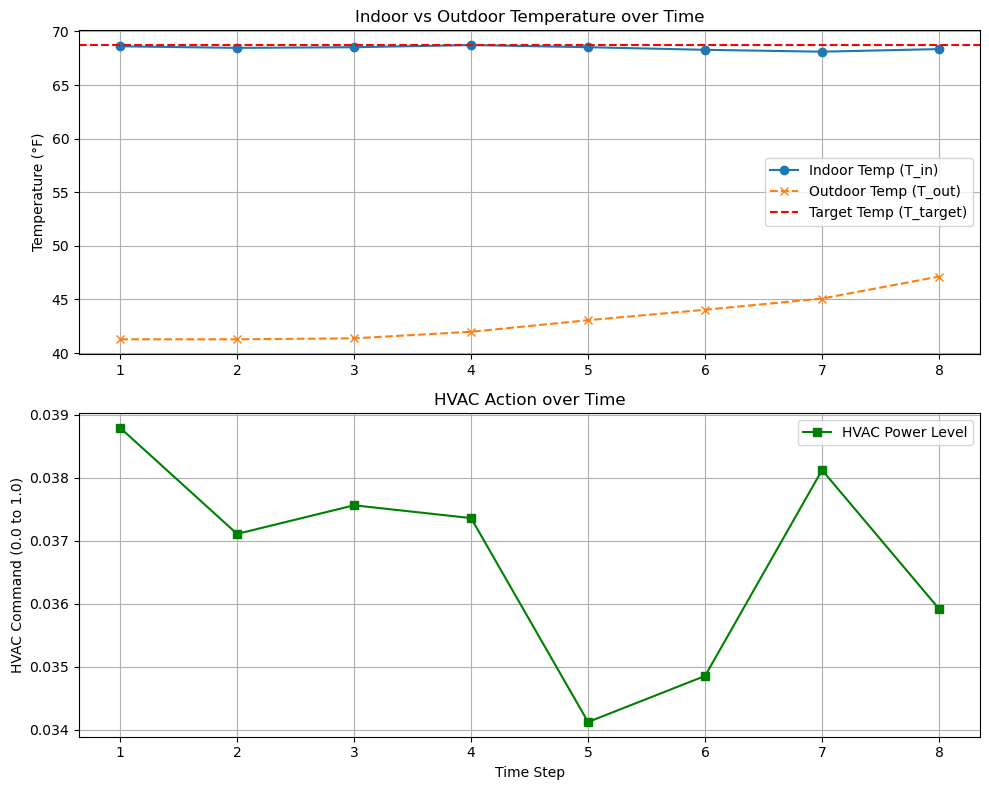

In [172]:
# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Indoor Temperature
axs[0].plot(time_steps, T_in_list, marker='o', label='Indoor Temp (T_in)')
axs[0].plot(time_steps, T_out_list, marker='x', linestyle='--', label='Outdoor Temp (T_out)')
axs[0].axhline(env.T_target, color='r', linestyle='--', label='Target Temp (T_target)')
axs[0].set_ylabel('Temperature (°F)')
axs[0].set_title('Indoor vs Outdoor Temperature over Time')
axs[0].legend()
axs[0].grid()

# Plot HVAC Actions
axs[1].plot(time_steps, action_list, marker='s', color='g', label='HVAC Power Level')
axs[1].set_ylabel('HVAC Command (0.0 to 1.0)')
axs[1].set_xlabel('Time Step')
axs[1].set_title('HVAC Action over Time')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


# traditional HVAC baseline

In [173]:
def traditional_hvac_baseline(env, threshold=1.0, hvac_power_on=1.0, episodes=1):
    total_energy = 0
    total_comfort_penalty = 0

    print("---- Traditional HVAC Baseline ----") 
    for ep in range(episodes):
        obs, _ = env.reset(seed = 42) # same seed for reproducibility of data point
        T_target = env.T_target
        episode_energy = 0
        episode_comfort = 0

        for step in range(env.episode_length):
            T_in, T_out, T_out_future, humid, wind_sp, time_step = obs

            # Rule-based control logic:
            if T_in > T_target + threshold:
                hvac_action = np.array([-hvac_power_on])  # Full cooling
            elif T_in < T_target - threshold:
                hvac_action = np.array([hvac_power_on])   # Full heating
            else:
                hvac_action = np.array([0.0])  # HVAC OFF

            obs, reward, done, _, _ = env.step(hvac_action)

            # Extract energy and comfort penalties for comparison
            energy_used = abs(hvac_action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            episode_energy += energy_used
            episode_comfort += comfort_penalty

            env.render()
            print(f"Action: {hvac_action[0]:.2f}, T_in: {env.T_in:.2f}°F, Energy: {energy_used:.2f}, Comfort Penalty: {comfort_penalty:.2f}")

            if done:
                break

        total_energy += episode_energy
        total_comfort_penalty += episode_comfort

        print(f"Episode {ep+1}: Energy = {episode_energy:.2f}, Comfort Penalty = {episode_comfort:.2f}")
        print("--------------------------------------------------")

    
    avg_energy = total_energy / episodes
    avg_comfort = total_comfort_penalty / episodes
    print("\n--- Traditional HVAC Summary ---")
    print(f"Avg Energy Used: {avg_energy:.2f}")
    print(f"Avg Comfort Penalty: {avg_comfort:.2f}")
    return avg_energy, avg_comfort


In [174]:
def advanced_hvac_baseline(env, threshold=1.0, episodes=1):
    total_energy = 0
    total_comfort_penalty = 0

    print("---- Advanced HVAC Baseline ----")
    for ep in range(episodes):
        obs, _ = env.reset(seed = 42)
        T_target = env.T_target
        episode_energy = 0
        episode_comfort = 0

        for step in range(env.episode_length):
            T_in, T_out, T_out_future, humid, wind_sp, time_step = obs

            # Optimized rule-based control logic:
            temp_diff = T_in - T_target
            if abs(temp_diff) > threshold:
                hvac_action = np.array([-temp_diff / (2 * threshold)])  # Scale power between -1 and 1
                hvac_action = np.clip(hvac_action, -1.0, 1.0)  # Ensure action stays within bounds
            else:
                hvac_action = np.array([0.0])  # HVAC OFF if within threshold

            obs, reward, done, _, _ = env.step(hvac_action)

            # Extract energy and comfort penalties for comparison
            energy_used = abs(hvac_action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            episode_energy += energy_used
            episode_comfort += comfort_penalty

            env.render()
            print(f"Action: {hvac_action[0]:.2f}, T_in: {env.T_in:.2f}°F, Energy: {energy_used:.2f}, Comfort Penalty: {comfort_penalty:.2f}")

            if done:
                break

        total_energy += episode_energy
        total_comfort_penalty += episode_comfort

        print(f"Episode {ep+1}: Energy = {episode_energy:.2f}, Comfort Penalty = {episode_comfort:.2f}")
        print("--------------------------------------------------")

    avg_energy = total_energy / episodes
    avg_comfort = total_comfort_penalty / episodes
    print("\n--- Advanced HVAC Summary ---")
    print(f"Avg Energy Used: {avg_energy:.2f}")
    print(f"Avg Comfort Penalty: {avg_comfort:.2f}")
    return avg_energy, avg_comfort

In [175]:
# After running traditional baseline and advanced baseline, compare with RL agent
# Now run your RL agent on the same env for comparison

def evaluate_rl_agent(env, model, episodes=1): # num of times prediction is being done
    total_energy = 0
    total_comfort_penalty = 0

    print("---- RL Agent Evaluation ----")
    for ep in range(episodes):
        obs, _ = env.reset(seed = 42)
        T_target = env.T_target
        episode_energy = 0
        episode_comfort = 0

        for step in range(env.episode_length): # single prediction time steps 
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)

            energy_used = abs(action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            episode_energy += energy_used
            episode_comfort += comfort_penalty

            env.render()
            print(f"Action: {action[0]:.2f}, T_in: {env.T_in:.2f}°F, Energy: {energy_used:.2f}, Comfort Penalty: {comfort_penalty:.2f}")

            if done:
                break

        total_energy += episode_energy
        total_comfort_penalty += episode_comfort

        print(f"Episode {ep+1}: Energy = {episode_energy:.2f}, Comfort Penalty = {episode_comfort:.2f}")
        print("--------------------------------------------------")

    avg_energy = total_energy / episodes
    avg_comfort = total_comfort_penalty / episodes
    print("\n--- RL Agent Summary ---")
    print(f"Avg Energy Used: {avg_energy:.2f}")
    print(f"Avg Comfort Penalty: {avg_comfort:.2f}")
    return avg_energy, avg_comfort


In [176]:
from tabulate import tabulate

# comparing all systems
# traditional 
avg_energy_baseline, avg_comfort_baseline = traditional_hvac_baseline(env, episodes=1)
# traditional advanced
avg_energy_advanced, avg_comfort_advanced = advanced_hvac_baseline(env, episodes=1)
# RL agent
avg_energy_rl, avg_comfort_rl = evaluate_rl_agent(env, model, episodes=1)

print("\n--- Final Comparison ---")
# Prepare the data for the table
table_data = [
    ["Avg Energy Used", f"{avg_energy_baseline:.2f}", f"{avg_energy_advanced:.2f}", f"{avg_energy_rl:.2f}"],
    ["Avg Comfort Penalty", f"{avg_comfort_baseline:.2f}", f"{avg_comfort_advanced:.2f}", f"{avg_comfort_rl:.2f}"]
]

# Print the table
headers = ["Metric", "Traditional HVAC", "Advanced HVAC", "RL Agent"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

---- Traditional HVAC Baseline ----
Step 0: T_in=74.51°F, T_out=60.1°F, Humid=72.0%, Wind=5.0 m/s
Step 1: T_in=74.32°F, T_out=63.3°F, Humid=68.0%, Wind=3.0 m/s
Action: 0.00, T_in: 74.32°F, Energy: 0.00, Comfort Penalty: 0.19
Step 2: T_in=74.34°F, T_out=65.4°F, Humid=68.0%, Wind=3.0 m/s
Action: 0.00, T_in: 74.34°F, Energy: 0.00, Comfort Penalty: 0.16
Step 3: T_in=74.07°F, T_out=66.3°F, Humid=63.0%, Wind=3.0 m/s
Action: 0.00, T_in: 74.07°F, Energy: 0.00, Comfort Penalty: 0.44
Step 4: T_in=73.77°F, T_out=69.9°F, Humid=52.0%, Wind=4.0 m/s
Action: 0.00, T_in: 73.77°F, Energy: 0.00, Comfort Penalty: 0.73
Step 5: T_in=73.57°F, T_out=70.6°F, Humid=60.0%, Wind=6.0 m/s
Action: 0.00, T_in: 73.57°F, Energy: 0.00, Comfort Penalty: 0.94
Step 6: T_in=73.08°F, T_out=71.5°F, Humid=56.0%, Wind=6.0 m/s
Action: 0.00, T_in: 73.08°F, Energy: 0.00, Comfort Penalty: 1.42
Step 7: T_in=78.15°F, T_out=73.5°F, Humid=56.0%, Wind=5.0 m/s
Action: 1.00, T_in: 78.15°F, Energy: 1.00, Comfort Penalty: 3.64
Step 8: T_in=

In [177]:
model.save("HVAC_RL_agent")